In [1]:
import time
start = time.time()

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
train = pd.read_csv('./data/train.csv', low_memory=False)

In [4]:
nombres = {'subscription_type':  'sub_type',
           'start_station_name': 'ss_name',
           'end_station_name':   'es_name',
           'start_station_id':   'sid',
           'end_station_id':     'es_id',
           'start_date':         's_date',
           'end_date':           'e_date',
           'zip_code':           'z_code',
           'bike_id':            'b_id'}

train.rename(columns=nombres, inplace=True)

train.drop(['ss_name', 'es_name', 'z_code', 'id','e_date','es_id'], axis=1, inplace=True)
train.rename(columns={'sid':'id'}, inplace=True)

train['s_date'] = pd.to_datetime(train['s_date'], format='%m/%d/%Y %H:%M')

train['year'] = train['s_date'].map(lambda x:x.year)
train['month'] = train['s_date'].map(lambda x:x.month)
train['day'] = train['s_date'].map(lambda x:x.day)
train['weekday'] = train['s_date'].map(lambda x: x.weekday())
train['hour'] = train['s_date'].map(lambda x:x.hour)
train['minute'] = train['s_date'].map(lambda x:x.minute)

train['date'] = pd.DatetimeIndex(train['s_date']).normalize()

train = train.merge(pd.get_dummies(train.sub_type), left_index=True, right_index=True)
train.drop('sub_type', axis=1, inplace=True)

In [5]:
train = train[train.duration <= 21600]

In [6]:
stations = pd.read_csv('./data/station.csv', low_memory=False)

In [7]:
stations.drop(['name','lat','long','installation_date'], axis=1, inplace=True)

In [8]:
weather = pd.read_csv('./data/weather.csv', low_memory=False)

In [9]:
def zip_ciudad(zip_code):
    if zip_code == 95113: return 'San Jose'
    elif zip_code == 94301: return 'Palo Alto'
    elif zip_code == 94107: return 'San Francisco'
    elif zip_code == 94063: return 'Redwood City'
    else: return 'Mountain View'

In [10]:
rename = {'max_temperature_f': 'max_temp', 
          'mean_temperature_f': 'mean_temp', 
          'min_temperature_f': 'min_temp', 
          'max_dew_point_f': 'max_dew', 
          'mean_dew_point_f': 'mean_dew', 
          'min_dew_point_f': 'min_dew', 
          'max_humidity': 'max_hum', 
          'mean_humidity': 'mean_hum', 
          'min_humidity': 'min_hum', 
          'max_sea_level_pressure_inches': 'max_slp', 
          'mean_sea_level_pressure_inches': 'mean_slp', 
          'min_sea_level_pressure_inches': 'min_slp', 
          'max_visibility_miles': 'max_vis', 
          'mean_visibility_miles': 'mean_vis', 
          'min_visibility_miles': 'min_vis', 
          'max_wind_Speed_mph': 'max_wind', 
          'mean_wind_speed_mph': 'mean_wind', 
          'max_gust_speed_mph': 'max_gust', 
          'precipitation_inches': 'precipitation', 
          'cloud_cover': 'cloud', 
          'wind_dir_degrees': 'wind_dir', 
          'zip_code': 'z_code'
         }

weather.rename(columns=rename, inplace=True)

weather['date'] = pd.to_datetime(weather['date'], format='%m/%d/%Y')
weather.loc[weather.events == 'rain', 'events'] = 'Rain'
weather.loc[weather.events.isnull(), 'events'] = 'Normal'
weather = weather.merge(pd.get_dummies(weather.events), left_index=True, right_index=True)

#weather.loc[weather.precipitation == 'T', 'precipitation'] = 0
#weather.precipitation = weather.precipitation.astype(np.float64)
weather.drop(['precipitation'], axis=1, inplace=True)

weather['city'] = weather['z_code'].map(zip_ciudad)

for i in weather:
    weather.drop(weather.loc[weather[i].isnull()].index, inplace=True)

In [11]:
df = pd.merge(train, stations, how='inner', on='id')

In [12]:
df.shape

(547395, 15)

In [13]:
df = pd.merge(df, weather, how='inner', on=['date','city'])

In [14]:
df.shape

(530864, 42)

In [15]:
df = df.merge(pd.get_dummies(df.city), left_index=True, right_index=True)

In [16]:
df.drop(['s_date','date','events','z_code','city'], axis=1, inplace=True)

In [17]:
df.isnull().sum()

duration             0
id                   0
b_id                 0
year                 0
month                0
day                  0
weekday              0
hour                 0
minute               0
Customer             0
Subscriber           0
dock_count           0
max_temp             0
mean_temp            0
min_temp             0
max_dew              0
mean_dew             0
min_dew              0
max_hum              0
mean_hum             0
min_hum              0
max_slp              0
mean_slp             0
min_slp              0
max_vis              0
mean_vis             0
min_vis              0
max_wind             0
mean_wind            0
max_gust             0
cloud                0
wind_dir             0
Fog                  0
Fog-Rain             0
Normal               0
Rain                 0
Rain-Thunderstorm    0
Mountain View        0
Palo Alto            0
Redwood City         0
San Francisco        0
San Jose             0
dtype: int64

In [18]:
from sklearn.preprocessing import normalize
Y = df.duration.values
df = normalize(df.drop(['duration'], axis=1))

In [19]:
from sklearn.model_selection import train_test_split
#from sklearn.feature_selection import SelectKBest
#from sklearn.decomposition import PCA
from sklearn.cross_decomposition import *
from sklearn.ensemble import * 
from sklearn.tree import *
from sklearn.neural_network import *
from sklearn.linear_model import *
from sklearn.metrics import mean_squared_error as mse
from sklearn.gaussian_process import *
from sklearn.kernel_ridge import *
from sklearn.neighbors import *
from sklearn.svm import *
from sklearn.model_selection import *

In [20]:
x = df[:3000]
y = Y[:3000]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

/home/mk/p2env/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/home/mk/p2env/lib/python2.7/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 18 iterations, i.e. alpha=1.096e-01, with an active set of 14 regressors, and the smallest cholesky pivot element being 3.495e-08
  ConvergenceWarning)
/home/mk/p2env/lib/python2.7/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=1.040e-01, with an active set of 15 regressors, and the smallest cholesky pivot element being 1.825e-08
  ConvergenceWarning)
/home/mk/p2env/lib/python2.7/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in acti

fin


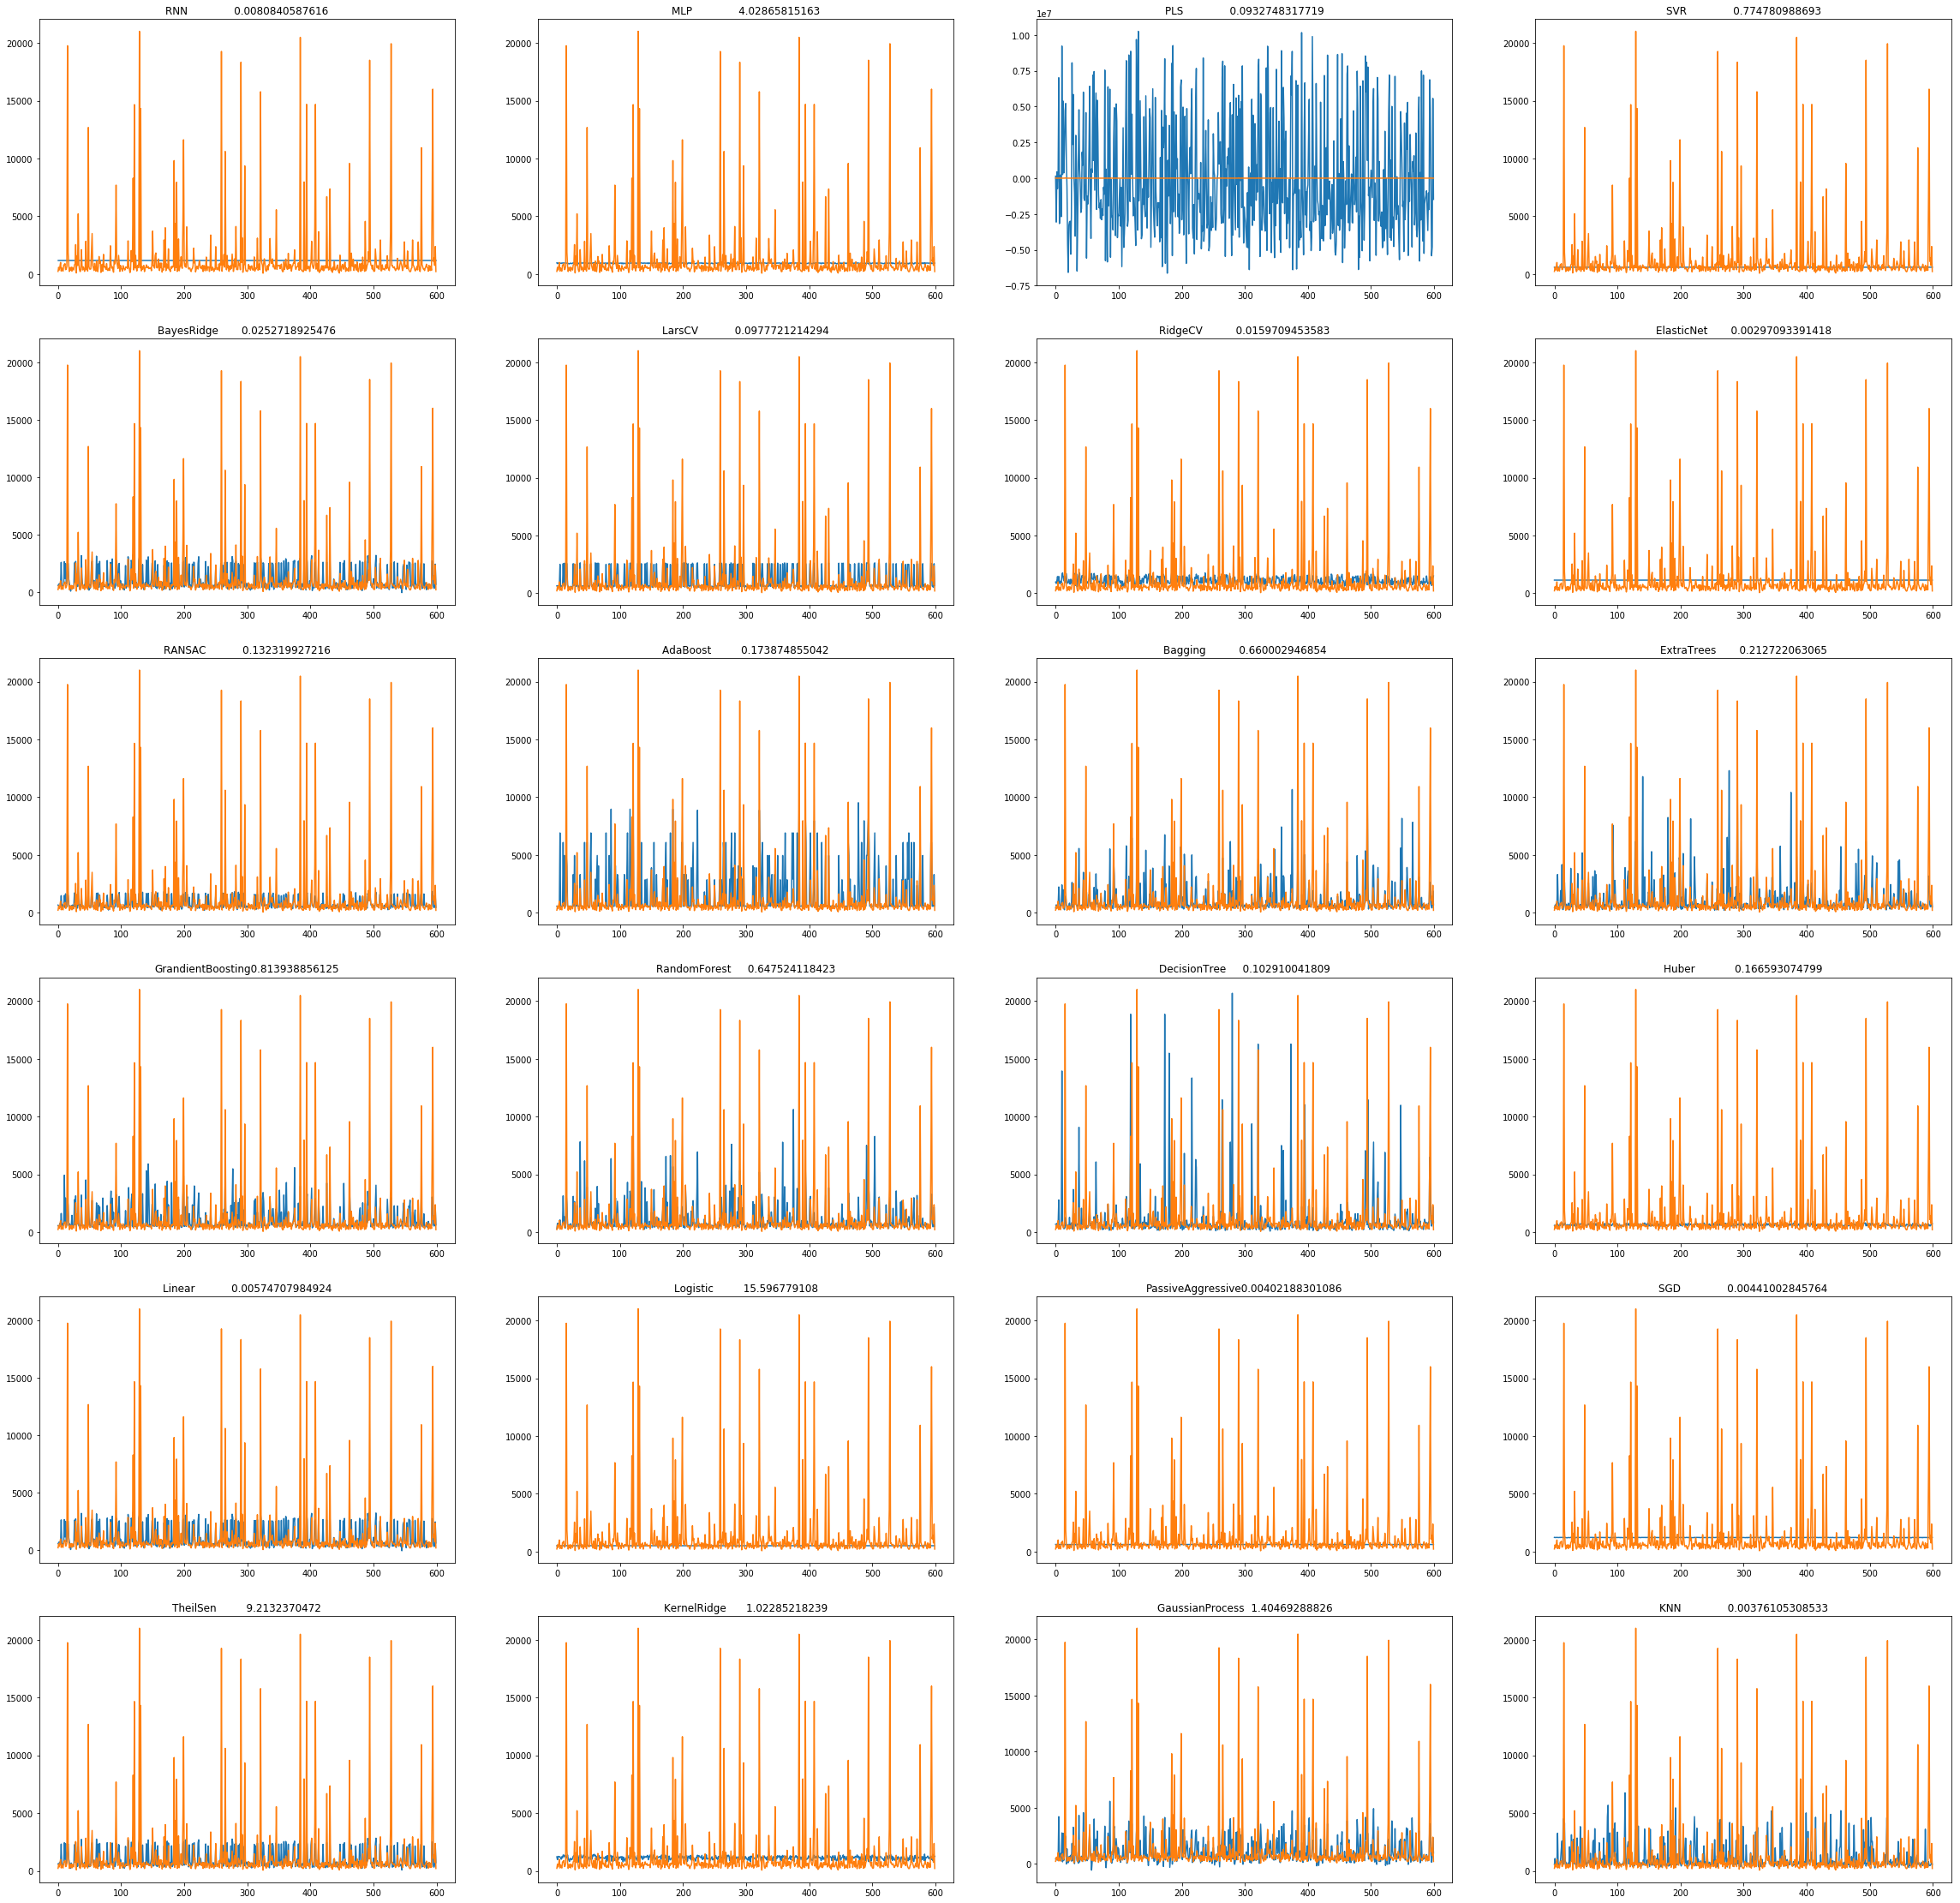

In [21]:
regs = {AdaBoostRegressor():         'AdaBoost         ',
        BaggingRegressor():          'Bagging          ',
        ExtraTreesRegressor():       'ExtraTrees       ',
        GradientBoostingRegressor(): 'GrandientBoosting',
        RandomForestRegressor():     'RandomForest     ',
        DecisionTreeRegressor():     'DecisionTree     ',
        HuberRegressor():            'Huber            ',
        LinearRegression():          'Linear           ',
        LogisticRegression():        'Logistic         ',
        PassiveAggressiveRegressor():'PassiveAggressive',
        RANSACRegressor():           'RANSAC           ',
        SGDRegressor():              'SGD              ',
        TheilSenRegressor():         'TheilSen         ',
        KernelRidge():               'KernelRidge      ',
        GaussianProcessRegressor():  'GaussianProcess  ',
        KNeighborsRegressor():       'KNN              ',
        RadiusNeighborsRegressor():  'RNN              ',
        MLPRegressor():              'MLP              ',
        PLSRegression():             'PLS              ',
        SVR():                       'SVR              ',
        ElasticNet():                'ElasticNet       ',
        BayesianRidge():             'BayesRidge       ',
        LarsCV():                    'LarsCV           ',
        RidgeCV():                   'RidgeCV          '
       }

def plots_de_predictores():
    plt.figure(figsize=(40, 40));
    i = 1
    for reg in regs:
        s1 = time.time()
        reg.fit(X_train, y_train)
        s2 = time.time()
        pred = reg.predict(X_test)
        score = mse(pred, y_test)
        plt.subplot(6, 4, i)
        plt.title(regs[reg] + str(s2-s1))
        plt.plot(pred)
        plt.plot(y_test)
        i += 1
    print 'fin'

plots_de_predictores()
    
def scores_de_predictores_CV_5():
    for reg in regs:
        print regs[reg],np.mean(cross_val_score(reg, x, y, cv=5, scoring="neg_mean_squared_error", n_jobs=1) * -1)

In [22]:
#Reestablecemos la cantidad de datos a _____
#(a mi se me cuelga la pc con 5.000)
x = df[:1000]
y = Y[:1000]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [ ]:
#Parametros para el Grid Search de ExtraTrees.
parametros = {"n_estimators": list(range(1,21)),
              "criterion": ["mse", "mae"],
             }

In [ ]:
#GridSearch de ExtraTrees.
clf = GridSearchCV(ExtraTreesRegressor(), parametros, cv=5, scoring="neg_mean_squared_error")
clf.fit(X_train, y_train)
print "Mejores parametros: "
print clf.best_params_

In [ ]:
ext1 = ExtraTreesRegressor()
ext2 = ExtraTreesRegressor(n_estimators=15, criterion="mae")

print "ExtraTrees sin CV: ",np.mean(cross_val_score(ext1, x, y, cv=5, scoring="neg_mean_squared_error", n_jobs=1) * -1)
print "ExtraTrees con CV: ",np.mean(cross_val_score(ext2, x, y, cv=5, scoring="neg_mean_squared_error", n_jobs=1) * -1)

In [ ]:
end = time.time()
print end-start